In [1]:
import pandas as pd
import random
import numpy as np

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random.seed(42)

In [3]:
PATH=r"D:\Dokumente\General_Data\other_people\Hard_Metalls\240422-new_data\worked_data\Paper\Data_Sets\\"

In [4]:
X_train_df=pd.read_csv(f"{PATH}X_train_240722.csv")
y_train=pd.read_csv(f"{PATH}y_train_240722.csv").Y

In [5]:
X_val_df = pd.read_csv(f"{PATH}X_val_240722.csv")
y_val = pd.read_csv(f"{PATH}y_val_240722.csv")

In [6]:
features_trost =  ['slope_0.2',  'norm_slope_0.2',  'curvature','curvature_linear', 'curvature_shift', 'norm_curvature','norm_curvature_linear', 'norm_curvature_shift', 'work_total','work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
features_others = ['Er(GPa)', 'H(GPa)']
all_features = features_trost.copy()
all_features.extend(features_others)

In [7]:
feature_sets = [features_trost, features_others, all_features]

In [8]:
svc = {
"name": "SVC",
"classifier" : SVC(kernel='rbf', class_weight='balanced'),
"smote": False,
"param_distributions": {
'model__C': np.logspace(-3, 3, 10),
'model__gamma': np.logspace(-3, 3, 10),
}}

In [9]:
knn = {
"name": "KNN",
"classifier" : KNeighborsClassifier(),
"param_distributions": {
'model__n_neighbors': range(1,20),
'model__weights': ['uniform', 'distance'],
'model__algorithm' : ["auto"],
'model__leaf_size': [10, 15, 30, 45]},
"smote": False}

In [10]:
models = [svc, knn]

In [11]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'accuracy': make_scorer(accuracy_score)}

In [12]:
results = pd.DataFrame()

In [13]:
cv = StratifiedKFold(n_splits = 4)

In [14]:
for model in models:
    for features in feature_sets:
        estimator = model["classifier"]
        print(model["name"])
        print(features)
       
        X = X_train_df[features]
        y = y_train
        print(f"scaled features used")

        
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", estimator)
                        ])
        
        
        param_grid = dict(reduce_dims__n_components = [0.5, 0.75, 0.95],
                          ridge__alpha = np.logspace(-5, 5, 10),
                          ridge__fit_intercept = [True, False],
                         )
    
            
        param_distributions = model["param_distributions"]
        random_search = RandomizedSearchCV(estimator=pipe,
                                       param_distributions=param_distributions,
                                    scoring=scoring,
                                       n_jobs=-1,
                                       cv=cv, n_iter=50, refit='f1_macro')
        
        random_search.fit(X, y)
        current_data = pd.DataFrame(random_search.cv_results_)
        current_data["model"] = [model["name"]]*len(current_data)
        current_data["smote"] = [model["smote"]]*len(current_data)
        current_data["features"] = [features]*len(current_data)
        current_data["num_features"] = [len(features)]*len(current_data)
        results = pd.concat([results, current_data])
        results = results.reset_index(drop=True)

SVC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
scaled features used
SVC
['Er(GPa)', 'H(GPa)']
scaled features used
SVC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio', 'Er(GPa)', 'H(GPa)']
scaled features used
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
scaled features used
KNN
['Er(GPa)', 'H(GPa)']
scaled features used
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvatu

In [16]:
current_data.model.unique()

array(['KNN'], dtype=object)

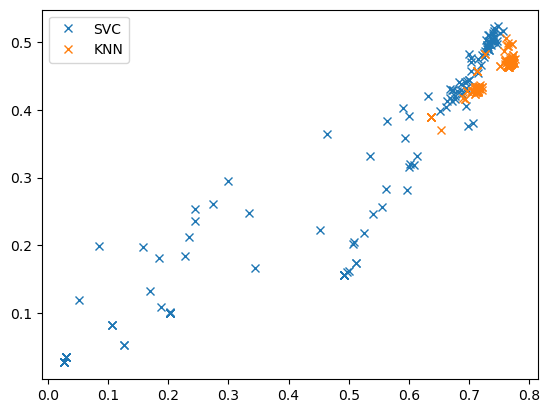

In [17]:
for model in results.model.unique():
    plot_data = results[results.model==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

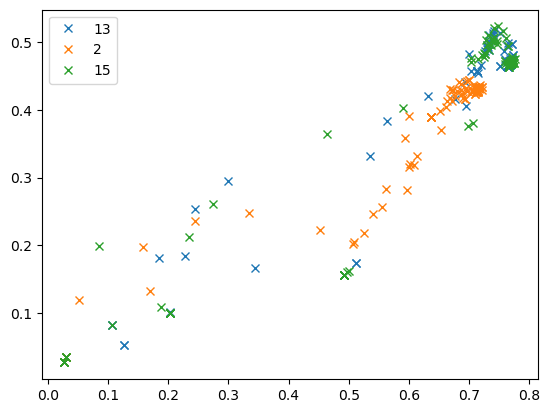

In [18]:
for model in results.num_features.unique():
    plot_data = results[results.num_features==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

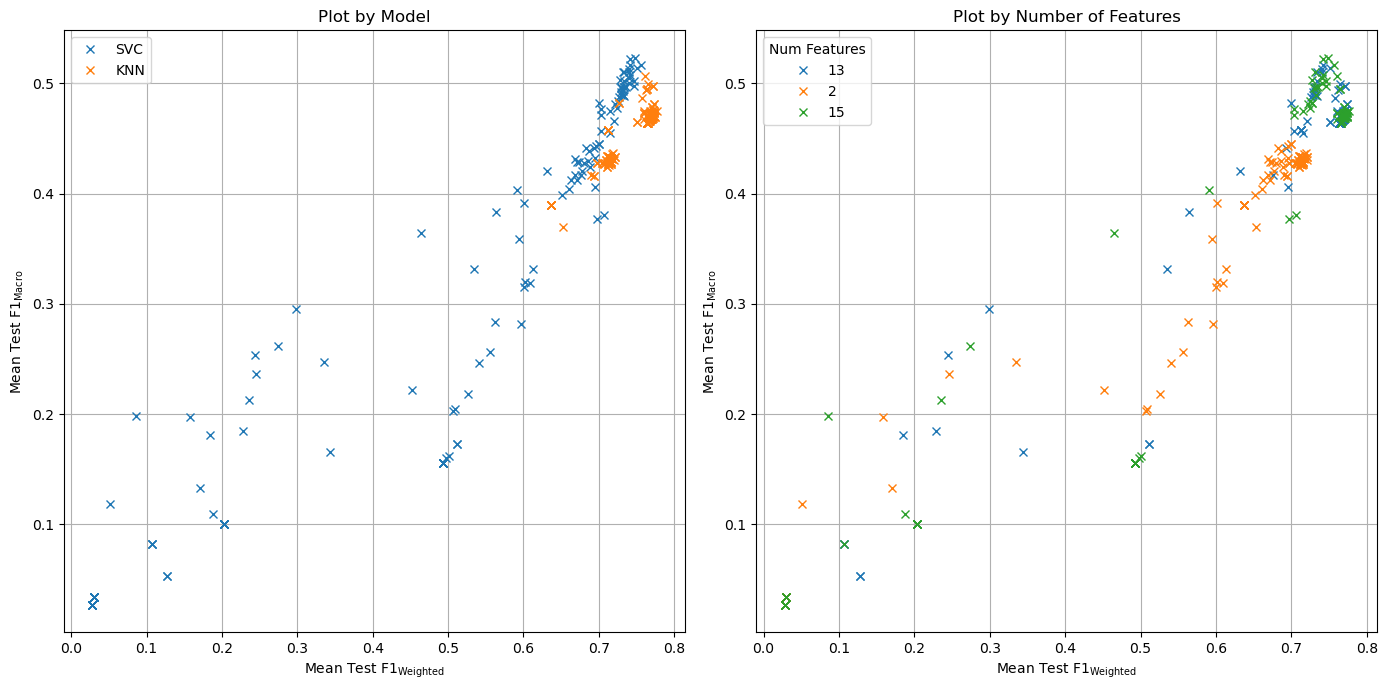

In [19]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot by model
for model in results['model'].unique():
    plot_data = results[results['model'] == model]
    ax1.plot(plot_data['mean_test_f1_weighted'], plot_data['mean_test_f1_macro'], 'x', label=model)
ax1.set_title('Plot by Model')
ax1.set_xlabel(r'Mean Test F1$_{\text{Weighted}}$')
ax1.set_ylabel(r'Mean Test F1$_{\text{Macro}}$')
ax1.legend()
ax1.grid(True)

# Plot by number of features
for num_features in results['num_features'].unique():
    plot_data = results[results['num_features'] == num_features]
    ax2.plot(plot_data['mean_test_f1_weighted'], plot_data['mean_test_f1_macro'], 'x', label=num_features)
ax2.set_title('Plot by Number of Features')
ax2.set_xlabel(r'Mean Test F1$_{\text{Weighted}}$')
ax2.set_ylabel(r'Mean Test F1$_{\text{Macro}}$')
ax2.legend(title='Num Features')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [20]:
results.to_pickle("random_search_used_svc_KNN_standard_scaler.pkl")